Device in use: cuda
Original image shape: (1024, 1024, 3) Type: uint8


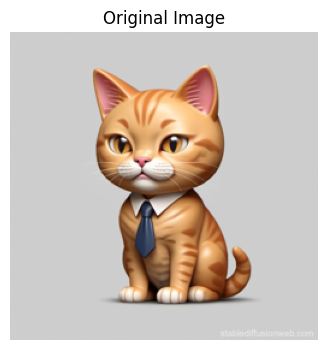

Iterations: 100%|██████████| 16/16 [00:01<00:00, 12.40it/s]


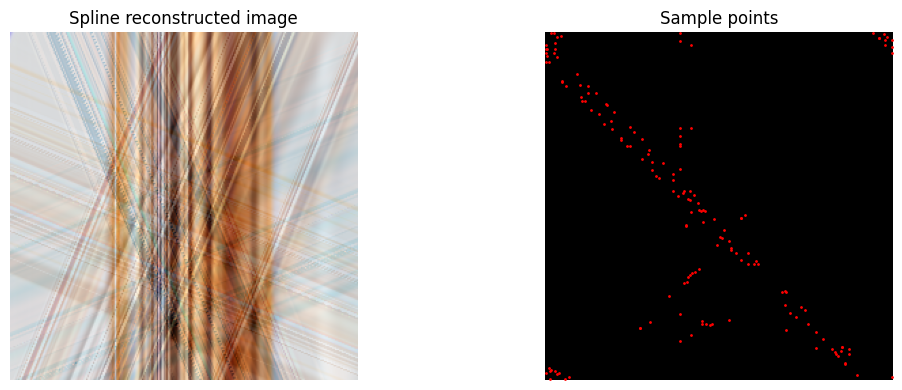

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import time
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio
from tqdm import tqdm
from PIL import Image

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device in use: {device}")

# Define functions to calculate MSE and PSNR
def calculate_metrics(original, reconstructed):
    mse_value = mean_squared_error(original, reconstructed)
    psnr_value = peak_signal_noise_ratio(original, reconstructed, data_range=original.max() - original.min())
    return mse_value, psnr_value

# Load image
image_url = "1.jpg"
image_original = imageio.imread(image_url)
print("Original image shape:", image_original.shape, "Type:", image_original.dtype)

image_pil = Image.fromarray(image_original)
image_original = np.array(image_pil.resize((256, 256)))

# Display the original image
plt.figure(figsize=(6, 4))
if image_original.dtype == np.float32 or image_original.dtype == np.float64:
    plt.imshow(image_original / 255.0)
else:
    plt.imshow(image_original)
plt.title('Original Image')
plt.axis('off')
plt.show()

# Convert to [0,1] if necessary
image = image_original.astype(np.float32)
if image.max() > 1.0:
    image /= 255.0
height, width, channels = image.shape

image_tensor = torch.tensor(image, dtype=torch.float32, device=device)

# Define functions
def generate_random_directions(num_directions):
    angles = np.linspace(0, 2 * np.pi, num_directions, endpoint=False, dtype=np.float32)
    angles = torch.tensor(angles, dtype=torch.float32, device=device)
    directions = [(torch.cos(angle), torch.sin(angle)) for angle in angles]
    return directions

def calculate_coordinates(Px, Py, dx, dy):
    return dx * Px + dy * Py

def build_1d_curve(Px, Py, values, dx, dy):
    coordinates = calculate_coordinates(Px, Py, dx, dy)
    sorted_coords, sorted_indices = torch.sort(coordinates)
    sorted_values = values[sorted_indices]

    # Process each channel separately
    curves = []
    for c in range(3):
        channel_values = sorted_values[:, c]
        unique_coords, inverse_indices, counts = torch.unique(
            sorted_coords, return_inverse=True, return_counts=True
        )
        sum_values = torch.zeros_like(unique_coords)
        sum_values = sum_values.scatter_add(0, inverse_indices, channel_values)
        mean_values = sum_values / counts.float()
        curves.append(torch.stack((unique_coords, mean_values), dim=1))
    return curves  # Returns curves for each channel

def predict_image(curves, dx, dy, width, height):
    Py, Px = torch.meshgrid(
        torch.arange(height, device=device),
        torch.arange(width, device=device),
        indexing='ij'
    )
    Px = Px.flatten()
    Py = Py.flatten()
    coordinates = calculate_coordinates(Px, Py, dx, dy)
    predicted_values = []
    for c in range(3):
        curve = curves[c]
        pv = torch_interp_spline(coordinates, curve[:, 0], curve[:, 1])
        predicted_values.append(pv)
    predicted_values = torch.stack(predicted_values, dim=1)
    predicted_values = torch.clamp(predicted_values, 0, 255)
    predicted_image = predicted_values.reshape((height, width, 3))
    return predicted_image

def downsample_pixels(Px, Py, sample_size=5000):
    total_pixels = len(Px)
    if total_pixels <= sample_size:
        return Px, Py
    else:
        sampled_indices = torch.randint(0, total_pixels, (sample_size,), device=device)
        return Px[sampled_indices], Py[sampled_indices]

def select_initial_sampling_points(num_points, width, height):
    x0 = torch.randint(0, width, (num_points,), device=device)
    y0 = torch.randint(0, height, (num_points,), device=device)
    return x0, y0

def torch_interp_lerp(x, xp, fp):
    indices = torch.searchsorted(xp, x)
    indices = torch.clamp(indices, 1, len(xp) - 1)

    x0 = xp[indices - 1]
    x1 = xp[indices]
    y0 = fp[indices - 1]
    y1 = fp[indices]

    weight = (x - x0) / (x1 - x0 + 1e-8)  # Avoid division by zero
    return torch.lerp(y0, y1, weight)

from scipy.interpolate import UnivariateSpline  
def torch_interp_spline(x, xp, fp, k=3):

    # Convert tensors to NumPy arrays
    x_np = x.cpu().numpy()
    xp_np = xp.cpu().numpy()
    fp_np = fp.cpu().numpy()
    
    # Get unique x points and corresponding y points
    unique_xp, unique_indices = np.unique(xp_np, return_index=True)
    unique_fp = fp_np[unique_indices]
    m = len(unique_xp)

    if m > k:
        k_adj = k
    else:
        return torch_interp_lerp(x, xp, fp)

    spline = UnivariateSpline(unique_xp, unique_fp, k=k_adj, s=0)
    y_np = spline(x_np)
    y = torch.from_numpy(y_np).to(x.device).type_as(x)
    return y

# Parameters for Analysis
num_directions_list = [16]  # Different number of directions to test
num_iterations_list = [16]
# Threshold for combinations
threshold = 16 * 960000

# Lists to store MSE and PSNR values for plotting
mse_history = []
psnr_history = []
iteration_history = []
mse_opt_history = []
psnr_opt_history = []

# Loop over combinations
for num_directions in num_directions_list:
    for num_iterations in num_iterations_list:
        # Generate Random Directions
        if num_directions * num_iterations > threshold:
            continue
        height, width, channels = image_tensor.shape
        directions = generate_random_directions(num_directions)
        initial_sample_size = 1
        sampled_Px, sampled_Py = select_initial_sampling_points(initial_sample_size, width, height)
        sampled_values = (image_tensor * 255.0)[sampled_Py, sampled_Px]

        Py, Px = torch.meshgrid(
            torch.arange(height, device=device),
            torch.arange(width, device=device),
            indexing='ij'
        )
        Px = Px.flatten()
        Py = Py.flatten()

        for t in tqdm(range(num_iterations), desc="Iterations"):
            downsampled_Px, downsampled_Py = downsample_pixels(Px, Py)
            av = (image_tensor * 255.0)[downsampled_Py, downsampled_Px]
            combined_predicted_values = torch.zeros_like(av, dtype=torch.float32, device=device)

            for idx in range(num_directions):
                dx, dy = directions[idx]
                curves = build_1d_curve(sampled_Px, sampled_Py, sampled_values, dx, dy)
                pv_channels = []
                for c in range(channels):
                    curve = curves[c]
                    pv = torch_interp_spline(
                        calculate_coordinates(downsampled_Px, downsampled_Py, dx, dy),
                        curve[:, 0], curve[:, 1]
                    )
                    pv_channels.append(pv)
                pv = torch.stack(pv_channels, dim=1)
                combined_predicted_values += pv

            combined_predicted_values /= num_directions
            downsampled_error = torch.max(torch.abs(av - combined_predicted_values), dim=1).values

            top_k_indices = torch.argsort(downsampled_error)[-10:]
            error_y = downsampled_Py[top_k_indices]
            error_x = downsampled_Px[top_k_indices]

            sampled_Px = torch.cat([sampled_Px, error_x])
            sampled_Py = torch.cat([sampled_Py, error_y])
            sampled_values = torch.cat([sampled_values, (image_tensor * 255.0)[error_y, error_x]])


        # Reconstruct images from predictions without storing all predicted images
        # Compute the average predicted image
        final_predicted_image_sum = torch.zeros((height, width, channels), device=device)
        for idx in range(num_directions):
            dx, dy = directions[idx]
            curves = build_1d_curve(sampled_Px, sampled_Py, sampled_values, dx, dy)
            predicted_image = predict_image(curves, dx, dy, width, height)
            # fig, axes = plt.subplots(1, 2, figsize=(12, 4))
            # axes[0].imshow(image_original / 255.0 if image_original.dtype in [np.float32, np.float64] else image_original)
            # axes[0].set_title(f'Original image')
            # axes[0].axis('off')
            # # Scale the predicted image to [0,1] for float or convert to uint8
            # if predicted_image.dtype == torch.float32 or predicted_image.dtype == torch.float64:
            #     imshow_image = predicted_image.clamp(0, 255).cpu().numpy() / 255.0
            # else:
            #     imshow_image = predicted_image.clamp(0, 255).cpu().numpy()
            # axes[1].imshow(imshow_image)
            # axes[1].set_title(f'One direction')
            # axes[1].axis('off')
            final_predicted_image_sum += predicted_image
        final_predicted_image_avg = final_predicted_image_sum / num_directions
        final_predicted_image_avg = torch.clamp(final_predicted_image_avg, 0, 255)
        reconstructed2_avg = final_predicted_image_avg.cpu().numpy() / 255.0

        # Evaluation metrics
        mse2_avg, psnr2_avg = calculate_metrics(image, reconstructed2_avg)
        mse_history.append(mse2_avg)
        psnr_history.append(psnr2_avg)
        iteration_history.append(num_iterations)

        # Optimized predicted image using least squares without storing all predicted images
        # Sample a subset of pixels for the least squares problem
        num_samples = 10000
        sample_indices = torch.randint(0, height * width, (num_samples,), device=device)
        sampled_Px_ls = (sample_indices % width).long()
        sampled_Py_ls = (sample_indices // width).long()
        original_values = (image_tensor * 255.0)[sampled_Py_ls, sampled_Px_ls]

        # Initialize X matrix for least squares
        X = torch.zeros((num_samples, num_directions, channels), device=device)
        for idx in range(num_directions):
            dx, dy = directions[idx]
            curves = build_1d_curve(sampled_Px, sampled_Py, sampled_values, dx, dy)
            for c in range(channels):
                curve = curves[c]
                predicted_values = torch_interp_spline(
                    calculate_coordinates(sampled_Px_ls, sampled_Py_ls, dx, dy),
                    curve[:, 0], curve[:, 1]
                )
                X[:, idx, c] = predicted_values

        # Solve least squares problem for each channel
        w_opt = torch.zeros((num_directions, channels), device=device)
        for c in range(channels):
            X_channel = X[:, :, c]
            y_channel = original_values[:, c]
            solution = torch.linalg.lstsq(X_channel, y_channel.unsqueeze(1))
            w_opt_channel = solution.solution.squeeze()
            w_opt[:, c] = w_opt_channel

        # Reconstruct the final predicted image using optimized weights
        final_predicted_image_opt = torch.zeros((height, width, channels), device=device)
        for idx in range(num_directions):
            dx, dy = directions[idx]
            curves = build_1d_curve(sampled_Px, sampled_Py, sampled_values, dx, dy)
            predicted_image = predict_image(curves, dx, dy, width, height)
            for c in range(channels):
                final_predicted_image_opt[:, :, c] += w_opt[idx, c] * predicted_image[:, :, c]

        final_predicted_image_opt = torch.clamp(final_predicted_image_opt, 0, 255)
        reconstructed2_opt = final_predicted_image_opt.cpu().numpy() / 255.0

        # Evaluation metrics
        mse2_opt, psnr2_opt = calculate_metrics(image, reconstructed2_opt)
        mse_opt_history.append(mse2_opt)
        psnr_opt_history.append(psnr2_opt)

        # Difference Image (Optimized - Original)
        difference_image = np.abs(reconstructed2_opt - image)

        # Plotting Results
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        # Average Predicted Image
        if final_predicted_image_avg.dtype == torch.float32 or final_predicted_image_avg.dtype == torch.float64:
            avg_image_display = final_predicted_image_avg.cpu().numpy() / 255.0
        else:
            avg_image_display = final_predicted_image_avg.cpu().numpy()
            
        # axes[0].imshow(image_original / 255.0 if image_original.dtype in [np.float32, np.float64] else image_original)
        # axes[0].set_title(f'Original image')
        # axes[0].axis('off')
        # Scale the predicted image to [0,1] for float or convert to uint8
        if predicted_image.dtype == torch.float32 or predicted_image.dtype == torch.float64:
            imshow_image = predicted_image.clamp(0, 255).cpu().numpy() / 255.0
        else:
            imshow_image = predicted_image.clamp(0, 255).cpu().numpy()
        axes[0].imshow(reconstructed2_opt)
        axes[0].set_title(f'Spline reconstructed image')
        axes[0].axis('off')

        # Difference Image
        axes[1].imshow(np.zeros((256,256)), cmap='gray')
        axes[1].scatter(sampled_Px.cpu(), sampled_Py.cpu(), c='red', s=1, label=f'Sample Points')
        axes[1].set_title('Sample points')
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()


Device in use: cuda
Original image shape: (1024, 1024, 3) Type: uint8


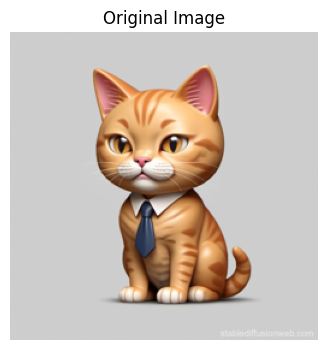

Iterations: 100%|██████████| 16/16 [00:00<00:00, 25.12it/s]


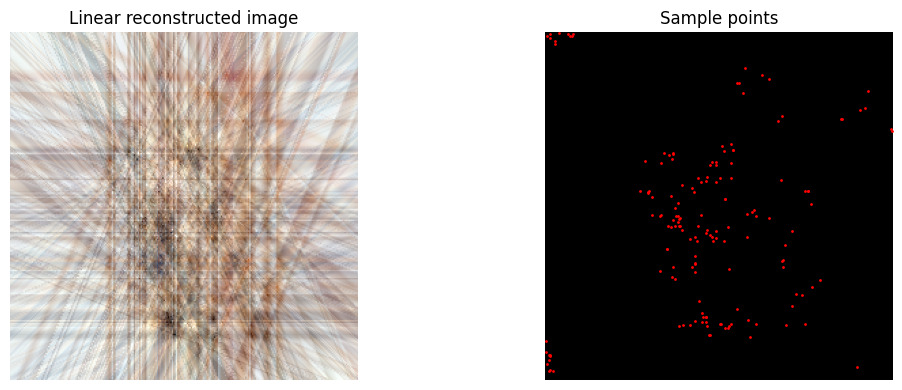

In [22]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import time
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio
from tqdm import tqdm
from PIL import Image

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device in use: {device}")

# Define functions to calculate MSE and PSNR
def calculate_metrics(original, reconstructed):
    mse_value = mean_squared_error(original, reconstructed)
    psnr_value = peak_signal_noise_ratio(original, reconstructed, data_range=original.max() - original.min())
    return mse_value, psnr_value

# Load image
image_url = "1.jpg"
image_original = imageio.imread(image_url)
print("Original image shape:", image_original.shape, "Type:", image_original.dtype)

image_pil = Image.fromarray(image_original)
image_original = np.array(image_pil.resize((256, 256)))

# Display the original image
plt.figure(figsize=(6, 4))
if image_original.dtype == np.float32 or image_original.dtype == np.float64:
    plt.imshow(image_original / 255.0)
else:
    plt.imshow(image_original)
plt.title('Original Image')
plt.axis('off')
plt.show()

# Convert to [0,1] if necessary
image = image_original.astype(np.float32)
if image.max() > 1.0:
    image /= 255.0
height, width, channels = image.shape

image_tensor = torch.tensor(image, dtype=torch.float32, device=device)

# Define functions
def generate_random_directions(num_directions):
    angles = np.linspace(0, 2 * np.pi, num_directions, endpoint=False, dtype=np.float32)
    angles = torch.tensor(angles, dtype=torch.float32, device=device)
    directions = [(torch.cos(angle), torch.sin(angle)) for angle in angles]
    return directions

def calculate_coordinates(Px, Py, dx, dy):
    return dx * Px + dy * Py

def build_1d_curve(Px, Py, values, dx, dy):
    coordinates = calculate_coordinates(Px, Py, dx, dy)
    sorted_coords, sorted_indices = torch.sort(coordinates)
    sorted_values = values[sorted_indices]

    # Process each channel separately
    curves = []
    for c in range(3):
        channel_values = sorted_values[:, c]
        unique_coords, inverse_indices, counts = torch.unique(
            sorted_coords, return_inverse=True, return_counts=True
        )
        sum_values = torch.zeros_like(unique_coords)
        sum_values = sum_values.scatter_add(0, inverse_indices, channel_values)
        mean_values = sum_values / counts.float()
        curves.append(torch.stack((unique_coords, mean_values), dim=1))
    return curves  # Returns curves for each channel

def predict_image(curves, dx, dy, width, height):
    Py, Px = torch.meshgrid(
        torch.arange(height, device=device),
        torch.arange(width, device=device),
        indexing='ij'
    )
    Px = Px.flatten()
    Py = Py.flatten()
    coordinates = calculate_coordinates(Px, Py, dx, dy)
    predicted_values = []
    for c in range(3):
        curve = curves[c]
        pv = torch_interp_spline(coordinates, curve[:, 0], curve[:, 1])
        predicted_values.append(pv)
    predicted_values = torch.stack(predicted_values, dim=1)
    predicted_values = torch.clamp(predicted_values, 0, 255)
    predicted_image = predicted_values.reshape((height, width, 3))
    return predicted_image

def downsample_pixels(Px, Py, sample_size=5000):
    total_pixels = len(Px)
    if total_pixels <= sample_size:
        return Px, Py
    else:
        sampled_indices = torch.randint(0, total_pixels, (sample_size,), device=device)
        return Px[sampled_indices], Py[sampled_indices]

def select_initial_sampling_points(num_points, width, height):
    x0 = torch.randint(0, width, (num_points,), device=device)
    y0 = torch.randint(0, height, (num_points,), device=device)
    return x0, y0

def torch_interp_lerp(x, xp, fp):
    indices = torch.searchsorted(xp, x)
    indices = torch.clamp(indices, 1, len(xp) - 1)

    x0 = xp[indices - 1]
    x1 = xp[indices]
    y0 = fp[indices - 1]
    y1 = fp[indices]

    weight = (x - x0) / (x1 - x0 + 1e-8)  # Avoid division by zero
    return torch.lerp(y0, y1, weight)

from scipy.interpolate import UnivariateSpline  
def torch_interp_spline(x, xp, fp):
    indices = torch.searchsorted(xp, x)
    indices = torch.clamp(indices, 1, len(xp) - 1)

    x0 = xp[indices - 1]
    x1 = xp[indices]
    y0 = fp[indices - 1]
    y1 = fp[indices]

    weight = (x - x0) / (x1 - x0 + 1e-8)  # Avoid division by zero
    return torch.lerp(y0, y1, weight)

# Parameters for Analysis
num_directions_list = [16]  # Different number of directions to test
num_iterations_list = [16]
# Threshold for combinations
threshold = 16 * 960000

# Lists to store MSE and PSNR values for plotting
mse_history = []
psnr_history = []
iteration_history = []
mse_opt_history = []
psnr_opt_history = []

# Loop over combinations
for num_directions in num_directions_list:
    for num_iterations in num_iterations_list:
        # Generate Random Directions
        if num_directions * num_iterations > threshold:
            continue
        height, width, channels = image_tensor.shape
        directions = generate_random_directions(num_directions)
        initial_sample_size = 1
        sampled_Px, sampled_Py = select_initial_sampling_points(initial_sample_size, width, height)
        sampled_values = (image_tensor * 255.0)[sampled_Py, sampled_Px]

        Py, Px = torch.meshgrid(
            torch.arange(height, device=device),
            torch.arange(width, device=device),
            indexing='ij'
        )
        Px = Px.flatten()
        Py = Py.flatten()

        for t in tqdm(range(num_iterations), desc="Iterations"):
            downsampled_Px, downsampled_Py = downsample_pixels(Px, Py)
            av = (image_tensor * 255.0)[downsampled_Py, downsampled_Px]
            combined_predicted_values = torch.zeros_like(av, dtype=torch.float32, device=device)

            for idx in range(num_directions):
                dx, dy = directions[idx]
                curves = build_1d_curve(sampled_Px, sampled_Py, sampled_values, dx, dy)
                pv_channels = []
                for c in range(channels):
                    curve = curves[c]
                    pv = torch_interp_spline(
                        calculate_coordinates(downsampled_Px, downsampled_Py, dx, dy),
                        curve[:, 0], curve[:, 1]
                    )
                    pv_channels.append(pv)
                pv = torch.stack(pv_channels, dim=1)
                combined_predicted_values += pv

            combined_predicted_values /= num_directions
            downsampled_error = torch.max(torch.abs(av - combined_predicted_values), dim=1).values

            top_k_indices = torch.argsort(downsampled_error)[-10:]
            error_y = downsampled_Py[top_k_indices]
            error_x = downsampled_Px[top_k_indices]

            sampled_Px = torch.cat([sampled_Px, error_x])
            sampled_Py = torch.cat([sampled_Py, error_y])
            sampled_values = torch.cat([sampled_values, (image_tensor * 255.0)[error_y, error_x]])


        # Reconstruct images from predictions without storing all predicted images
        # Compute the average predicted image
        final_predicted_image_sum = torch.zeros((height, width, channels), device=device)
        for idx in range(num_directions):
            dx, dy = directions[idx]
            curves = build_1d_curve(sampled_Px, sampled_Py, sampled_values, dx, dy)
            predicted_image = predict_image(curves, dx, dy, width, height)
            # fig, axes = plt.subplots(1, 2, figsize=(12, 4))
            # axes[0].imshow(image_original / 255.0 if image_original.dtype in [np.float32, np.float64] else image_original)
            # axes[0].set_title(f'Original image')
            # axes[0].axis('off')
            # # Scale the predicted image to [0,1] for float or convert to uint8
            # if predicted_image.dtype == torch.float32 or predicted_image.dtype == torch.float64:
            #     imshow_image = predicted_image.clamp(0, 255).cpu().numpy() / 255.0
            # else:
            #     imshow_image = predicted_image.clamp(0, 255).cpu().numpy()
            # axes[1].imshow(imshow_image)
            # axes[1].set_title(f'One direction')
            # axes[1].axis('off')
            final_predicted_image_sum += predicted_image
        final_predicted_image_avg = final_predicted_image_sum / num_directions
        final_predicted_image_avg = torch.clamp(final_predicted_image_avg, 0, 255)
        reconstructed2_avg = final_predicted_image_avg.cpu().numpy() / 255.0

        # Evaluation metrics
        mse2_avg, psnr2_avg = calculate_metrics(image, reconstructed2_avg)
        mse_history.append(mse2_avg)
        psnr_history.append(psnr2_avg)
        iteration_history.append(num_iterations)

        # Optimized predicted image using least squares without storing all predicted images
        # Sample a subset of pixels for the least squares problem
        num_samples = 10000
        sample_indices = torch.randint(0, height * width, (num_samples,), device=device)
        sampled_Px_ls = (sample_indices % width).long()
        sampled_Py_ls = (sample_indices // width).long()
        original_values = (image_tensor * 255.0)[sampled_Py_ls, sampled_Px_ls]

        # Initialize X matrix for least squares
        X = torch.zeros((num_samples, num_directions, channels), device=device)
        for idx in range(num_directions):
            dx, dy = directions[idx]
            curves = build_1d_curve(sampled_Px, sampled_Py, sampled_values, dx, dy)
            for c in range(channels):
                curve = curves[c]
                predicted_values = torch_interp_spline(
                    calculate_coordinates(sampled_Px_ls, sampled_Py_ls, dx, dy),
                    curve[:, 0], curve[:, 1]
                )
                X[:, idx, c] = predicted_values

        # Solve least squares problem for each channel
        w_opt = torch.zeros((num_directions, channels), device=device)
        for c in range(channels):
            X_channel = X[:, :, c]
            y_channel = original_values[:, c]
            solution = torch.linalg.lstsq(X_channel, y_channel.unsqueeze(1))
            w_opt_channel = solution.solution.squeeze()
            w_opt[:, c] = w_opt_channel

        # Reconstruct the final predicted image using optimized weights
        final_predicted_image_opt = torch.zeros((height, width, channels), device=device)
        for idx in range(num_directions):
            dx, dy = directions[idx]
            curves = build_1d_curve(sampled_Px, sampled_Py, sampled_values, dx, dy)
            predicted_image = predict_image(curves, dx, dy, width, height)
            for c in range(channels):
                final_predicted_image_opt[:, :, c] += w_opt[idx, c] * predicted_image[:, :, c]

        final_predicted_image_opt = torch.clamp(final_predicted_image_opt, 0, 255)
        reconstructed2_opt = final_predicted_image_opt.cpu().numpy() / 255.0

        # Evaluation metrics
        mse2_opt, psnr2_opt = calculate_metrics(image, reconstructed2_opt)
        mse_opt_history.append(mse2_opt)
        psnr_opt_history.append(psnr2_opt)

        # Difference Image (Optimized - Original)
        difference_image = np.abs(reconstructed2_opt - image)

        # Plotting Results
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        # Average Predicted Image
        if final_predicted_image_avg.dtype == torch.float32 or final_predicted_image_avg.dtype == torch.float64:
            avg_image_display = final_predicted_image_avg.cpu().numpy() / 255.0
        else:
            avg_image_display = final_predicted_image_avg.cpu().numpy()
            
        # axes[0].imshow(image_original / 255.0 if image_original.dtype in [np.float32, np.float64] else image_original)
        # axes[0].set_title(f'Original image')
        # axes[0].axis('off')
        # Scale the predicted image to [0,1] for float or convert to uint8
        if predicted_image.dtype == torch.float32 or predicted_image.dtype == torch.float64:
            imshow_image = predicted_image.clamp(0, 255).cpu().numpy() / 255.0
        else:
            imshow_image = predicted_image.clamp(0, 255).cpu().numpy()
        axes[0].imshow(reconstructed2_opt)
        axes[0].set_title(f'Linear reconstructed image')
        axes[0].axis('off')

        # Difference Image
        axes[1].imshow(np.zeros((256,256)), cmap='gray')
        axes[1].scatter(sampled_Px.cpu(), sampled_Py.cpu(), c='red', s=1, label=f'Sample Points')
        axes[1].set_title('Sample points')
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()


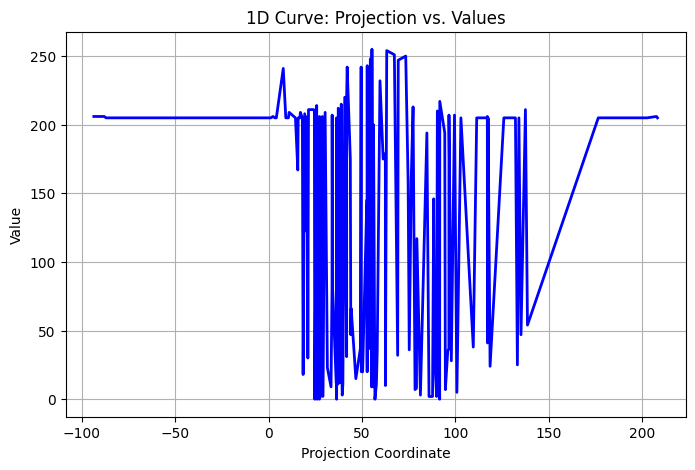

In [40]:
def plot_curve(curve):
  
    coordinates = curve[:, 0] 
    values = curve[:, 1]      

    plt.figure(figsize=(8, 5))
    plt.plot(coordinates, values, color='blue', linewidth=2)
    plt.title('1D Curve: Projection vs. Values')
    plt.xlabel('Projection Coordinate')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()
plot_curve(np.array(curves[2].cpu()))

Device in use: cuda
Original image shape: (1024, 1024, 3) Type: uint8


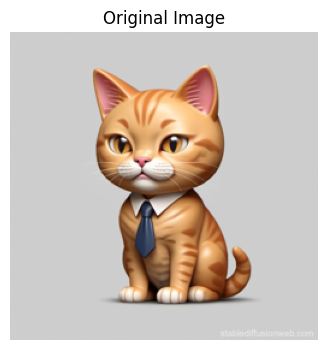

Iterations (Linear): 100%|██████████| 16/16 [00:00<00:00, 21.58it/s]


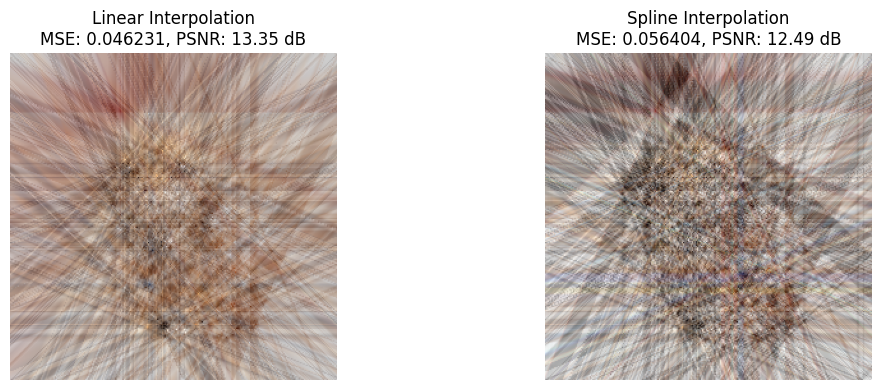

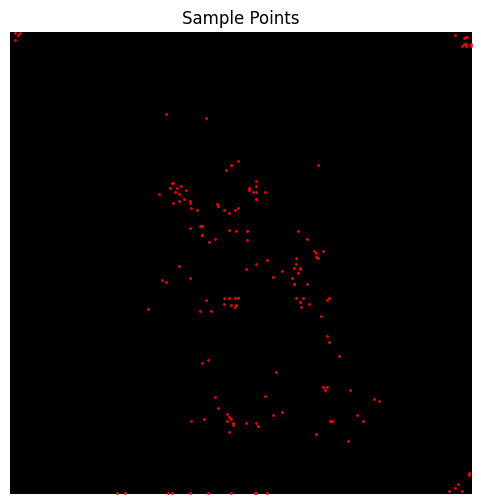

: 

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio
from tqdm import tqdm
from PIL import Image

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device in use: {device}")

# Define functions to calculate MSE and PSNR
def calculate_metrics(original, reconstructed):
    mse_value = mean_squared_error(original, reconstructed)
    psnr_value = peak_signal_noise_ratio(original, reconstructed, data_range=original.max() - original.min())
    return mse_value, psnr_value

# Load image
image_path = "1.jpg"  # Make sure the image path is correct
image_original = imageio.imread(image_path)
print("Original image shape:", image_original.shape, "Type:", image_original.dtype)

# Resize and convert to uint8 if necessary
image_pil = Image.fromarray(image_original)
image_original = np.array(image_pil.resize((256, 256))).astype(np.uint8)

# Display the original image
plt.figure(figsize=(6, 4))
plt.imshow(image_original)
plt.title('Original Image')
plt.axis('off')
plt.show()

# Convert to tensor and normalize to [0,1]
image_tensor = torch.tensor(image_original, dtype=torch.float32, device=device) / 255.0
height, width, channels = image_tensor.shape

# Define functions
def generate_random_directions(num_directions):
    angles = np.linspace(0, 2 * np.pi, num_directions, endpoint=False, dtype=np.float32)
    angles = torch.tensor(angles, dtype=torch.float32, device=device)
    directions = [(torch.cos(angle), torch.sin(angle)) for angle in angles]
    return directions

def calculate_coordinates(Px, Py, dx, dy):
    return dx * Px + dy * Py

def build_1d_curve(Px, Py, values, dx, dy):
    coordinates = calculate_coordinates(Px, Py, dx, dy)
    sorted_coords, sorted_indices = torch.sort(coordinates)
    sorted_values = values[sorted_indices]

    # Process each channel separately
    curves = []
    for c in range(3):
        channel_values = sorted_values[:, c]
        unique_coords, inverse_indices, counts = torch.unique(
            sorted_coords, return_inverse=True, return_counts=True
        )
        sum_values = torch.zeros_like(unique_coords)
        sum_values = sum_values.scatter_add(0, inverse_indices, channel_values)
        mean_values = sum_values / counts.float()
        curves.append(torch.stack((unique_coords, mean_values), dim=1))
    return curves  # Returns curves for each channel

def predict_image(curves, dx, dy, width, height, interp_method='spline'):
    Py, Px = torch.meshgrid(
        torch.arange(height, device=device),
        torch.arange(width, device=device),
        indexing='ij'
    )
    Px = Px.flatten()
    Py = Py.flatten()
    coordinates = calculate_coordinates(Px, Py, dx, dy)
    predicted_values = []
    for c in range(3):
        curve = curves[c]
        if interp_method == 'spline':
            pv = torch_interp_spline(coordinates, curve[:, 0], curve[:, 1])
        elif interp_method == 'linear':
            pv = torch_interp_lerp(coordinates, curve[:, 0], curve[:, 1])
        else:
            raise ValueError("Unknown interpolation method")
        predicted_values.append(pv)
    predicted_values = torch.stack(predicted_values, dim=1)
    predicted_values = torch.clamp(predicted_values, 0, 1)
    predicted_image = predicted_values.reshape((height, width, 3))
    return predicted_image

def downsample_pixels(Px, Py, sample_size=5000):
    total_pixels = len(Px)
    if total_pixels <= sample_size:
        return Px, Py
    else:
        sampled_indices = torch.randint(0, total_pixels, (sample_size,), device=device)
        return Px[sampled_indices], Py[sampled_indices]

def select_initial_sampling_points(num_points, width, height):
    x0 = torch.randint(0, width, (num_points,), device=device)
    y0 = torch.randint(0, height, (num_points,), device=device)
    return x0, y0

def torch_interp_lerp(x, xp, fp):
    indices = torch.searchsorted(xp, x)
    indices = torch.clamp(indices, 1, len(xp) - 1)

    x0 = xp[indices - 1]
    x1 = xp[indices]
    y0 = fp[indices - 1]
    y1 = fp[indices]

    weight = (x - x0) / (x1 - x0 + 1e-8)  # Avoid division by zero
    return torch.lerp(y0, y1, weight)

from scipy.interpolate import UnivariateSpline
def torch_interp_spline(x, xp, fp, k=3):
    # Convert tensors to NumPy arrays
    x_np = x.cpu().numpy()
    xp_np = xp.cpu().numpy()
    fp_np = fp.cpu().numpy()
    
    # Get unique x points and corresponding y points
    unique_xp, unique_indices = np.unique(xp_np, return_index=True)
    unique_fp = fp_np[unique_indices]
    m = len(unique_xp)

    if m > k:
        k_adj = k
    else:
        return torch_interp_lerp(x, xp, fp)

    spline = UnivariateSpline(unique_xp, unique_fp, k=k_adj, s=0)
    y_np = spline(x_np)
    y = torch.from_numpy(y_np).to(x.device).type_as(x)
    return y

# Parameters for Analysis
num_directions = 16  # Number of directions to use
num_iterations = 16  # Number of iterations

# Lists to store MSE and PSNR values
mse_history_linear = []
psnr_history_linear = []
mse_history_spline = []
psnr_history_spline = []

# Generate Random Directions
directions = generate_random_directions(num_directions)
initial_sample_size = 1
sampled_Px, sampled_Py = select_initial_sampling_points(initial_sample_size, width, height)
sampled_values = image_tensor[sampled_Py, sampled_Px]

Py, Px = torch.meshgrid(
    torch.arange(height, device=device),
    torch.arange(width, device=device),
    indexing='ij'
)
Px = Px.flatten()
Py = Py.flatten()

# Initialize the same sample points list to use for both methods
sampled_Px_all = sampled_Px.clone()
sampled_Py_all = sampled_Py.clone()
sampled_values_all = sampled_values.clone()

# Iterative Sampling using Linear Interpolation
for t in tqdm(range(num_iterations), desc="Iterations (Linear)"):
    downsampled_Px, downsampled_Py = downsample_pixels(Px, Py)
    av = image_tensor[downsampled_Py, downsampled_Px]
    combined_predicted_values = torch.zeros_like(av, dtype=torch.float32, device=device)

    for idx in range(num_directions):
        dx, dy = directions[idx]
        curves = build_1d_curve(sampled_Px, sampled_Py, sampled_values, dx, dy)
        pv_channels = []
        for c in range(channels):
            curve = curves[c]
            pv = torch_interp_lerp(
                calculate_coordinates(downsampled_Px, downsampled_Py, dx, dy),
                curve[:, 0], curve[:, 1]
            )
            pv_channels.append(pv)
        pv = torch.stack(pv_channels, dim=1)
        combined_predicted_values += pv

    combined_predicted_values /= num_directions
    downsampled_error = torch.max(torch.abs(av - combined_predicted_values), dim=1).values

    top_k_indices = torch.argsort(downsampled_error)[-10:]
    error_y = downsampled_Py[top_k_indices]
    error_x = downsampled_Px[top_k_indices]

    sampled_Px = torch.cat([sampled_Px, error_x])
    sampled_Py = torch.cat([sampled_Py, error_y])
    sampled_values = torch.cat([sampled_values, image_tensor[error_y, error_x]])

    # Collect sample points for spline interpolation
    sampled_Px_all = torch.cat([sampled_Px_all, error_x])
    sampled_Py_all = torch.cat([sampled_Py_all, error_y])
    sampled_values_all = torch.cat([sampled_values_all, image_tensor[error_y, error_x]])

# Reconstruction using Linear Interpolation
final_predicted_image_linear = torch.zeros((height, width, channels), device=device)
for idx in range(num_directions):
    dx, dy = directions[idx]
    curves = build_1d_curve(sampled_Px, sampled_Py, sampled_values, dx, dy)
    predicted_image = predict_image(curves, dx, dy, width, height, interp_method='linear')
    final_predicted_image_linear += predicted_image
final_predicted_image_linear /= num_directions
final_predicted_image_linear = torch.clamp(final_predicted_image_linear, 0, 1)
reconstructed_linear = final_predicted_image_linear.cpu().numpy()

# Compute MSE and PSNR for Linear Interpolation
mse_linear, psnr_linear = calculate_metrics(image_tensor.cpu().numpy(), reconstructed_linear)
mse_history_linear.append(mse_linear)
psnr_history_linear.append(psnr_linear)

# Reconstruction using Spline Interpolation with same sample points
sampled_Px_spline = sampled_Px_all
sampled_Py_spline = sampled_Py_all
sampled_values_spline = sampled_values_all

final_predicted_image_spline = torch.zeros((height, width, channels), device=device)
for idx in range(num_directions):
    dx, dy = directions[idx]
    curves = build_1d_curve(sampled_Px_spline, sampled_Py_spline, sampled_values_spline, dx, dy)
    predicted_image = predict_image(curves, dx, dy, width, height, interp_method='spline')
    final_predicted_image_spline += predicted_image
final_predicted_image_spline /= num_directions
final_predicted_image_spline = torch.clamp(final_predicted_image_spline, 0, 1)
reconstructed_spline = final_predicted_image_spline.cpu().numpy()

# Compute MSE and PSNR for Spline Interpolation
mse_spline, psnr_spline = calculate_metrics(image_tensor.cpu().numpy(), reconstructed_spline)
mse_history_spline.append(mse_spline)
psnr_history_spline.append(psnr_spline)

# Plotting Results
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Original Image
# axes[0].imshow(image_original)
# axes[0].set_title('Original Image')
# axes[0].axis('off')

# Reconstructed Image using Linear Interpolation
axes[0].imshow((reconstructed_linear * 255).astype(np.uint8))
axes[0].set_title(f'Linear Interpolation\nMSE: {mse_linear:.6f}, PSNR: {psnr_linear:.2f} dB')
axes[0].axis('off')

# Reconstructed Image using Spline Interpolation
axes[1].imshow((reconstructed_spline * 255).astype(np.uint8))
axes[1].set_title(f'Spline Interpolation\nMSE: {mse_spline:.6f}, PSNR: {psnr_spline:.2f} dB')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Plot Sample Points
plt.figure(figsize=(6, 6))
plt.imshow(np.zeros((height, width, 3)), cmap='gray')
plt.scatter(sampled_Px_all.cpu(), sampled_Py_all.cpu(), c='red', s=1)
plt.title('Sample Points')
plt.axis('off')
plt.show()
